In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the data
data = pd.read_csv('Crab_molt.csv')
data = data.rename(columns={'pre molt size': 'presz', 'post molt size': 'postsz'})

# Drop NaN values
data = data.dropna()

In [2]:
# Define features and target
X = data[['postsz']].values  # Input feature
y = data['presz'].values     # Target variable

# Split the data into 50% train and 50% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Standardize the data (fit on train, transform on train and test)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# X_train_scaled and y_train_scaled are now ready for training


Epoch 1/100


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1039 - mae: 0.7624 - val_loss: 0.4495 - val_mae: 0.4510
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.3489 - mae: 0.4078 - val_loss: 0.1128 - val_mae: 0.1975
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 0.0860 - mae: 0.1874 - val_loss: 0.0444 - val_mae: 0.1453
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0344 - mae: 0.1351 - val_loss: 0.0315 - val_mae: 0.1391
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0223 - mae: 0.1140 - val_loss: 0.0266 - val_mae: 0.1310
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0179 - mae: 0.1030 - val_loss: 0.0240 - val_mae: 0.1274
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.0149 - mae: 0.0976 - val_loss: 0.0231 - val_mae: 0.1268
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.0171 - mae: 0.1043 - val_loss: 0.0215 - val_mae: 0.1226
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0

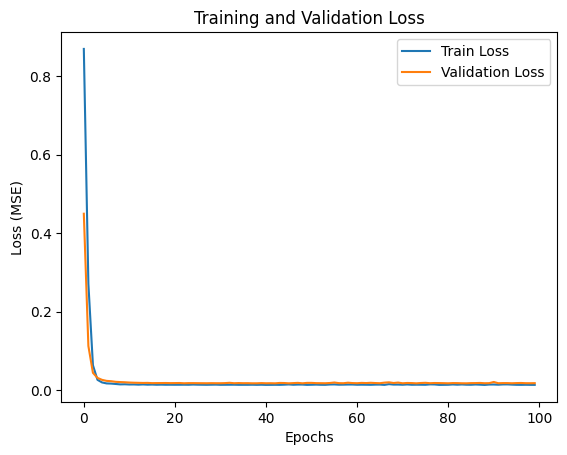

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=8, validation_split=0.2, verbose=1)

# Display training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [4]:
import tensorflow as tf

# Define a function that takes input data and returns the neural network's prediction
def nn_function(x):
    # Ensure x is in the right shape for prediction
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tf.reshape(x, (1, -1))  # Reshape to be compatible with the model's input shape
    return model(x)

# Choose a point around which to calculate the Taylor series (e.g., the first point in X_test_scaled)
x0 = tf.convert_to_tensor(X_test_scaled[0], dtype=tf.float32)

# Compute the first few derivatives of the function around x0
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x0)
    f_x0 = nn_function(x0)
    # First derivative
    f_prime = tape.gradient(f_x0, x0)
    # Second derivative
    f_double_prime = tape.gradient(f_prime, x0)
    # Third derivative
    f_triple_prime = tape.gradient(f_double_prime, x0)

# Display the Taylor series terms
print("f(x0):", f_x0.numpy())
print("f'(x0):", f_prime.numpy())
print("f''(x0):", f_double_prime.numpy())
print("f'''(x0):", f_triple_prime.numpy())


f(x0): [[0.8082245]]
f'(x0): [0.97046167]
f''(x0): [0.]
f'''(x0): [0.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, beta3]


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


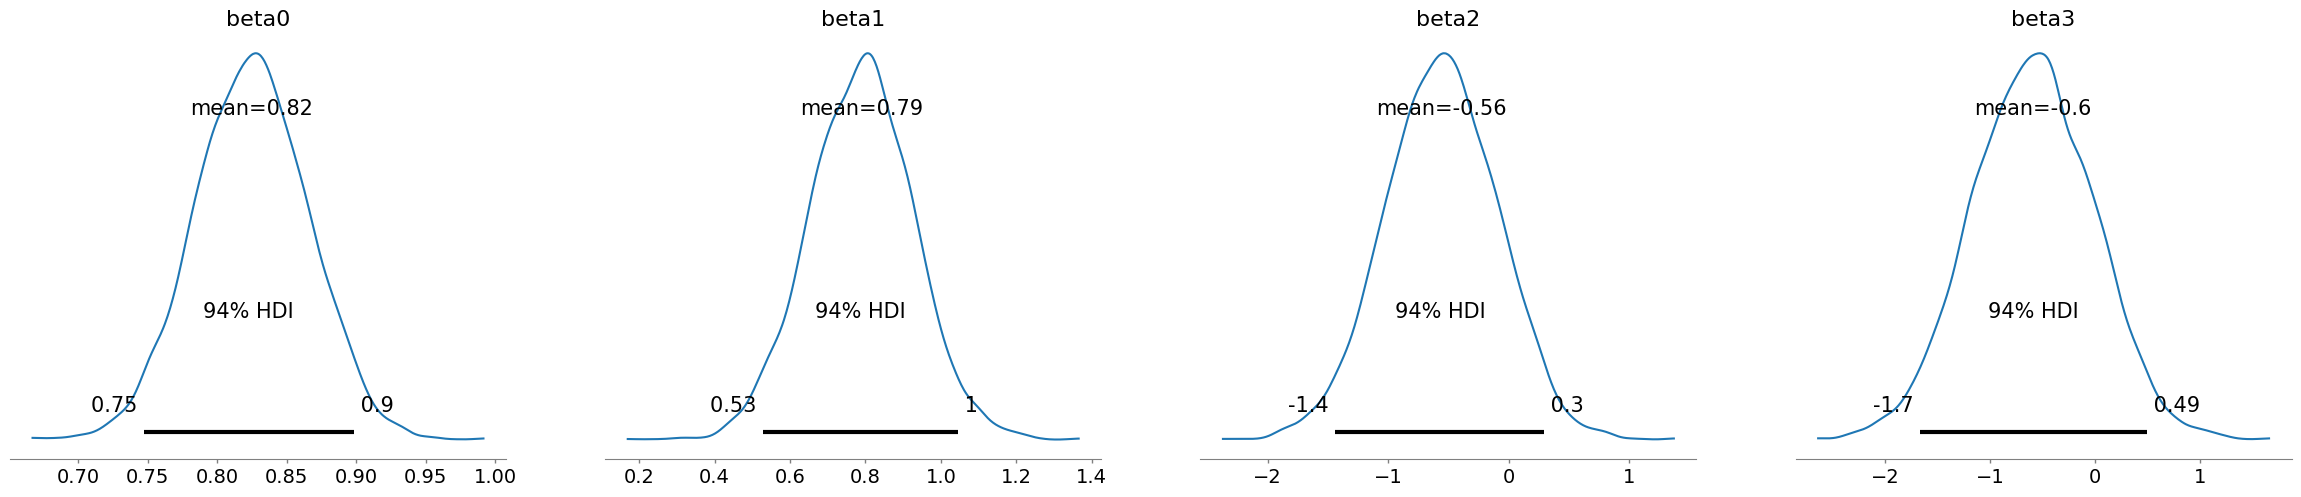

In [7]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Define the Taylor approximation function
def taylor_approximation(x, beta0, beta1, beta2, beta3):
    x_diff = x - X_test_scaled[0]  # Using the first test point as the reference point
    return beta0 + beta1 * x_diff + beta2 * (x_diff ** 2) / 2 + beta3 * (x_diff ** 3) / 6

# Run MCMC on the Taylor approximation function
with pm.Model() as taylor_model:
    # Priors for Taylor series coefficients with Normal distribution around initial derivatives
    beta0 = pm.Normal('beta0', mu=float(f_x0), sigma=1)
    beta1 = pm.Normal('beta1', mu=float(f_prime), sigma=1)
    beta2 = pm.Normal('beta2', mu=float(f_double_prime), sigma=1)
    beta3 = pm.Normal('beta3', mu=float(f_triple_prime), sigma=1)
    
    # Observed data (for demonstration, using a small subset)
    x_obs = X_test_scaled[:10].reshape(-1)  # Flatten to ensure 1D shape
    y_obs = y_test_scaled[:10].reshape(-1)  # Flatten to ensure 1D shape
    y_hat = taylor_approximation(x_obs, beta0, beta1, beta2, beta3)
    
    # Reshape y_hat to ensure it matches y_obs dimensions
    y_hat = pm.math.flatten(y_hat)
    
    # Likelihood of observed data given Taylor series approximation
    likelihood = pm.Normal('y_obs', mu=y_hat, sigma=0.1, observed=y_obs)
    
    # Sample from the posterior
    trace = pm.sample(2000, return_inferencedata=True)

# Visualize the posterior distributions
az.plot_posterior(trace, var_names=['beta0', 'beta1', 'beta2', 'beta3'])
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


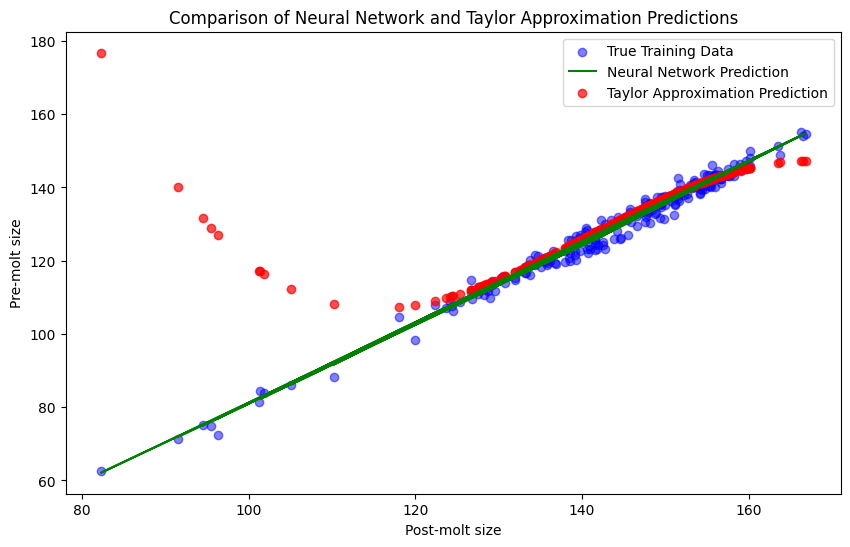

In [9]:
# Extract the means of each beta from the posterior distributions
beta0_mean = trace.posterior['beta0'].mean().item()
beta1_mean = trace.posterior['beta1'].mean().item()
beta2_mean = trace.posterior['beta2'].mean().item()
beta3_mean = trace.posterior['beta3'].mean().item()

# Define the Taylor approximation function using the mean values
def taylor_approximation_mean(x):
    x_diff = x - X_test_scaled[0]  # Using x0 as the reference point
    return beta0_mean + beta1_mean * x_diff + beta2_mean * (x_diff ** 2) / 2 + beta3_mean * (x_diff ** 3) / 6

# Generate predictions
# Neural network predictions on the training data
nn_predictions = scaler_y.inverse_transform(model.predict(X_train_scaled).reshape(-1, 1)).flatten()

# Taylor approximation predictions on the training data
taylor_predictions = scaler_y.inverse_transform(
    np.array([taylor_approximation_mean(x) for x in X_train_scaled]).reshape(-1, 1)
).flatten()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(scaler_X.inverse_transform(X_train_scaled), scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1)), 
            label='True Training Data', color='blue', alpha=0.5)
plt.plot(scaler_X.inverse_transform(X_train_scaled), nn_predictions, label='Neural Network Prediction', color='green')
plt.scatter(scaler_X.inverse_transform(X_train_scaled), taylor_predictions, label='Taylor Approximation Prediction', color='red', alpha=0.7)
plt.xlabel('Post-molt size')
plt.ylabel('Pre-molt size')
plt.title('Comparison of Neural Network and Taylor Approximation Predictions')
plt.legend()
plt.show()

In [13]:
# Initial parameters from the posterior distributions after MCMC sampling
sigma_likelihood = 0.1  # Assumed fixed variance for each observation

# Store mean and variance for each beta parameter based on initial MCMC sampling
beta_params = {
    'beta0': {'mean': trace.posterior['beta0'].mean().item(), 'var': trace.posterior['beta0'].var().item()},
    'beta1': {'mean': trace.posterior['beta1'].mean().item(), 'var': trace.posterior['beta1'].var().item()},
    'beta2': {'mean': trace.posterior['beta2'].mean().item(), 'var': trace.posterior['beta2'].var().item()},
    'beta3': {'mean': trace.posterior['beta3'].mean().item(), 'var': trace.posterior['beta3'].var().item()}
}

# Display initial means and variances for each parameter
print("Initial Beta Parameters from MCMC:")
for beta, params in beta_params.items():
    print(f"{beta}: Mean = {params['mean']}, Variance = {params['var']}")

# Function to update the posterior parameters for each beta after observing a new data point
def analytical_bayesian_update(beta_params, new_x, new_y):
    x_diff = new_x - X_test_scaled[0]  # Reference to x0 for Taylor approximation

    # Calculate current prediction using Taylor approximation with current mean values
    y_hat = (
        beta_params['beta0']['mean'] +
        beta_params['beta1']['mean'] * x_diff +
        beta_params['beta2']['mean'] * (x_diff ** 2) / 2 +
        beta_params['beta3']['mean'] * (x_diff ** 3) / 6
    )

    # For each beta, update the mean and variance based on the new observation
    for beta_key, beta in beta_params.items():
        mu_prior = beta['mean']
        sigma_prior_sq = beta['var']
        
        # Use the likelihood mean as y_hat (prediction for the current x_diff)
        mu_likelihood = y_hat
        
        # Update posterior mean and variance
        mu_posterior = (sigma_likelihood**2 * mu_prior + sigma_prior_sq * mu_likelihood) / (sigma_prior_sq + sigma_likelihood**2)
        sigma_posterior_sq = (sigma_prior_sq * sigma_likelihood**2) / (sigma_prior_sq + sigma_likelihood**2)
        
        # Update beta mean and variance
        beta['mean'] = mu_posterior
        beta['var'] = sigma_posterior_sq

    return beta_params

# Sequential update with each new data point from the test set
for new_x, new_y in zip(X_test_scaled[10:], y_test_scaled[10:]):
    beta_params = analytical_bayesian_update(beta_params, new_x, new_y)

# Display final updated means and variances for each parameter
print("\nUpdated Beta Parameters after Sequential Updates:")
for beta, params in beta_params.items():
    print(f"{beta}: Mean = {params['mean']}, Variance = {params['var']}")


Initial Beta Parameters from MCMC:
beta0: Mean = 0.8244773013942739, Variance = 0.0016631347218560885
beta1: Mean = 0.7887470942692562, Variance = 0.019153987480786207
beta2: Mean = -0.5591565458522926, Variance = 0.21741181942854704
beta3: Mean = -0.5962842058825212, Variance = 0.3397716171961231

Updated Beta Parameters after Sequential Updates:
beta0: Mean = [0.02363912], Variance = 4.310108105975645e-05
beta1: Mean = [0.00414529], Variance = 4.414580601277656e-05
beta2: Mean = [0.00221852], Variance = 4.423878410598747e-05
beta3: Mean = [0.00225483], Variance = 4.424202605881981e-05


In [15]:
import numpy as np
import pymc as pm
import arviz as az

# Retrieve all MCMC samples for each beta parameter as initial posterior samples
initial_samples = {
    'beta0': trace.posterior['beta0'].values.flatten(),
    'beta1': trace.posterior['beta1'].values.flatten(),
    'beta2': trace.posterior['beta2'].values.flatten(),
    'beta3': trace.posterior['beta3'].values.flatten()
}

# Set the likelihood variance (assumed known)
sigma_likelihood = 0.1

# Function to calculate the likelihood of the new observation given beta samples
def calculate_likelihood(y_obs, x_obs, beta_samples):
    x_diff = x_obs - X_test_scaled[0]
    predictions = (beta_samples['beta0'] +
                   beta_samples['beta1'] * x_diff +
                   beta_samples['beta2'] * (x_diff ** 2) / 2 +
                   beta_samples['beta3'] * (x_diff ** 3) / 6)
    
    # Calculate Gaussian likelihood
    likelihoods = np.exp(-0.5 * ((y_obs - predictions) ** 2) / sigma_likelihood**2) / (np.sqrt(2 * np.pi) * sigma_likelihood)
    
    # Check for NaN values in likelihoods
    if np.any(np.isnan(likelihoods)):
        print("Warning: NaN values found in likelihoods. Setting NaNs to zero.")
        likelihoods = np.nan_to_num(likelihoods, nan=0.0)  # Replace NaNs with zero

    return likelihoods

# Function to update posterior samples based on a new observation
def update_posterior_with_new_data(y_new, x_new, current_samples):
    # Calculate the likelihood weights for each sample based on the new observation
    likelihood_weights = calculate_likelihood(y_new, x_new, current_samples)
    
    # Normalize weights to sum to 1, ensuring we have valid probabilities
    total_weight = np.sum(likelihood_weights)
    if total_weight == 0:
        print("Warning: Sum of likelihood weights is zero. Adding a small constant to weights.")
        likelihood_weights += 1e-10  # Small constant to avoid zero division
    
    likelihood_weights /= np.sum(likelihood_weights)
    
    # Resample from the current samples based on the likelihood weights to form the new posterior
    updated_samples = {
        key: np.random.choice(values, size=len(values), p=likelihood_weights)
        for key, values in current_samples.items()
    }
    
    return updated_samples

# Sequentially update posterior samples with each new data point in the test set
updated_samples = initial_samples
for new_x, new_y in zip(X_test_scaled[10:], y_test_scaled[10:]):
    updated_samples = update_posterior_with_new_data(new_y, new_x, updated_samples)

# Calculate final means and variances for each beta parameter
final_means = {key: np.mean(values) for key, values in updated_samples.items()}
final_variances = {key: np.var(values) for key, values in updated_samples.items()}

# Display initial and final means and variances
print("Initial Beta Parameters from MCMC:")
for beta, values in initial_samples.items():
    print(f"{beta}: Mean = {np.mean(values)}, Variance = {np.var(values)}")

print("\nUpdated Beta Parameters after Sequential Updates:")
for beta in updated_samples.keys():
    print(f"{beta}: Mean = {final_means[beta]}, Variance = {final_variances[beta]}")

# Display the difference between initial and updated parameters
print("\nDifference in Beta Parameters (Updated - Initial):")
for beta in initial_samples.keys():
    mean_diff = final_means[beta] - np.mean(initial_samples[beta])
    var_diff = final_variances[beta] - np.var(initial_samples[beta])
    print(f"{beta}: Mean Difference = {mean_diff}, Variance Difference = {var_diff}")

Initial Beta Parameters from MCMC:
beta0: Mean = 0.8244773013942739, Variance = 0.0016631347218560885
beta1: Mean = 0.7887470942692562, Variance = 0.019153987480786207
beta2: Mean = -0.5591565458522926, Variance = 0.21741181942854704
beta3: Mean = -0.5962842058825212, Variance = 0.3397716171961231

Updated Beta Parameters after Sequential Updates:
beta0: Mean = 0.7812895847250952, Variance = 1.322853583956494e-05
beta1: Mean = 0.8680155621909583, Variance = 0.0
beta2: Mean = -0.5563154752027476, Variance = 1.232595164407831e-32
beta3: Mean = -0.4875228487570283, Variance = 1.232595164407831e-32

Difference in Beta Parameters (Updated - Initial):
beta0: Mean Difference = -0.043187716669178644, Variance Difference = -0.0016499061860165236
beta1: Mean Difference = 0.07926846792170217, Variance Difference = -0.019153987480786207
beta2: Mean Difference = 0.0028410706495449745, Variance Difference = -0.21741181942854704
beta3: Mean Difference = 0.1087613571254929, Variance Difference = -0.33

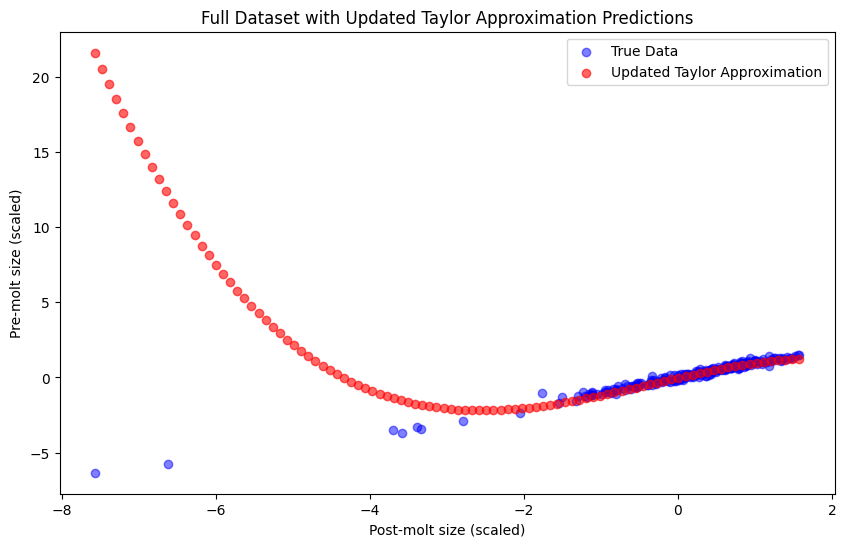

In [17]:
import matplotlib.pyplot as plt

# Define the updated Taylor series approximation function using the final means
def updated_taylor_approximation(x, beta_means):
    x_diff = x - X_test_scaled[0]
    return (
        beta_means['beta0'] +
        beta_means['beta1'] * x_diff +
        beta_means['beta2'] * (x_diff ** 2) / 2 +
        beta_means['beta3'] * (x_diff ** 3) / 6
    )

# Generate predictions for the full dataset range using the updated Taylor approximation
X_full = np.linspace(X_test_scaled.min(), X_test_scaled.max(), 100)
y_taylor_updated = updated_taylor_approximation(X_full, final_means)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled, y_test_scaled, color='blue', alpha=0.5, label="True Data")

# Plot the updated Taylor approximation predictions
plt.scatter(X_full, y_taylor_updated, color='red', alpha=0.6, label="Updated Taylor Approximation")

plt.xlabel("Post-molt size (scaled)")
plt.ylabel("Pre-molt size (scaled)")
plt.title("Full Dataset with Updated Taylor Approximation Predictions")
plt.legend()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


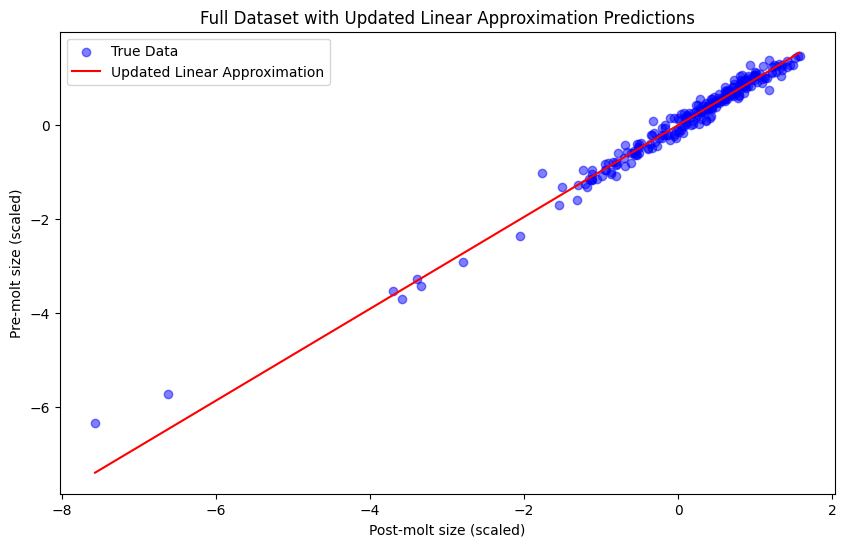

In [18]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Define the simplified Taylor series model with only beta0 and beta1
with pm.Model() as linear_taylor_model:
    # Priors for beta0 and beta1
    beta0 = pm.Normal('beta0', mu=0, sigma=1)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    
    # Expected value of outcome (linear approximation)
    y_hat = beta0 + beta1 * X_train_scaled.flatten()
    
    # Likelihood of observed data given linear model
    sigma = 0.1  # assumed known likelihood standard deviation
    y_obs = pm.Normal('y_obs', mu=y_hat, sigma=sigma, observed=y_train_scaled)
    
    # MCMC sampling
    trace_linear = pm.sample(3000, return_inferencedata=True)

# Retrieve all MCMC samples for beta0 and beta1
initial_samples_linear = {
    'beta0': trace_linear.posterior['beta0'].values.flatten(),
    'beta1': trace_linear.posterior['beta1'].values.flatten()
}

# Sequential update function for linear model
def update_posterior_with_new_data_linear(y_new, x_new, current_samples):
    # Calculate the likelihood weights for each sample based on the new observation
    predictions = current_samples['beta0'] + current_samples['beta1'] * x_new
    likelihood_weights = np.exp(-0.5 * ((y_new - predictions) ** 2) / sigma**2) / (np.sqrt(2 * np.pi) * sigma)
    
    # Normalize weights to sum to 1
    likelihood_weights /= np.sum(likelihood_weights)
    
    # Resample from the current samples based on the likelihood weights to form the new posterior
    updated_samples = {
        key: np.random.choice(values, size=len(values), p=likelihood_weights)
        for key, values in current_samples.items()
    }
    
    return updated_samples

# Sequentially update posterior samples with each new data point in the test set
updated_samples_linear = initial_samples_linear
for new_x, new_y in zip(X_test_scaled[10:], y_test_scaled[10:]):
    updated_samples_linear = update_posterior_with_new_data_linear(new_y, new_x, updated_samples_linear)

# Calculate final means for beta0 and beta1 after updates
final_means_linear = {key: np.mean(values) for key, values in updated_samples_linear.items()}

# Plotting the results

# Define the updated linear approximation function
def updated_linear_approximation(x, beta_means):
    return beta_means['beta0'] + beta_means['beta1'] * x

# Generate predictions using the updated linear approximation
X_full = np.linspace(X_test_scaled.min(), X_test_scaled.max(), 100)
y_linear_updated = updated_linear_approximation(X_full, final_means_linear)

# Plot the original data and the updated linear approximation
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled, y_test_scaled, color='blue', alpha=0.5, label="True Data")
plt.plot(X_full, y_linear_updated, color='red', label="Updated Linear Approximation")
plt.xlabel("Post-molt size (scaled)")
plt.ylabel("Pre-molt size (scaled)")
plt.title("Full Dataset with Updated Linear Approximation Predictions")
plt.legend()
plt.show()

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Split the data into 50% for training and 50% for testing
X_train, X_new, y_train, y_new = train_test_split(data[['postsz']], data['presz'], test_size=0.5, random_state=42)

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
X_new_scaled = scaler_x.transform(X_new)
y_new_scaled = scaler_y.transform(y_new.values.reshape(-1, 1)).flatten()

# Train a simple neural network on the first 50% of the data
nn = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)
nn.fit(X_train_scaled, y_train_scaled)

MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)

In [26]:
# Taylor linear approximation function
def linear_taylor_approximation(x, nn_model, x0):
    # Get predictions and the slope at x0
    y0 = nn_model.predict([x0])[0]
    grad = (nn_model.predict([x0 + 1e-5])[0] - y0) / 1e-5  # Approximate derivative
    
    # Return the linear approximation as beta0 + beta1 * x
    return y0, grad

# Use the midpoint of X_train for the Taylor expansion
x0 = np.array([X_train_scaled.mean()])
beta0, beta1 = linear_taylor_approximation(x0, nn, x0)

In [27]:
import pymc as pm
import arviz as az

with pm.Model() as initial_linear_model:
    # Set priors based on initial Taylor approximation
    beta0_prior = pm.Normal('beta0', mu=beta0, sigma=1)
    beta1_prior = pm.Normal('beta1', mu=beta1, sigma=1)
    
    # Define the linear model for y given x
    y_hat = beta0_prior + beta1_prior * X_train_scaled.flatten()
    
    # Likelihood of the observed data
    sigma = 0.1
    y_obs = pm.Normal('y_obs', mu=y_hat, sigma=sigma, observed=y_train_scaled)
    
    # MCMC sampling for initial beta0 and beta1
    trace_initial = pm.sample(3000, return_inferencedata=True)

# Store initial posterior samples for beta0 and beta1
initial_samples = {
    'beta0': trace_initial.posterior['beta0'].values.flatten(),
    'beta1': trace_initial.posterior['beta1'].values.flatten()
}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


In [31]:
# Function to update posterior samples based on a new observation
def update_posterior_with_new_data(y_new, x_new, current_samples):
    predictions = current_samples['beta0'] + current_samples['beta1'] * x_new
    likelihood_weights = np.exp(-0.5 * ((y_new - predictions) ** 2) / sigma**2) / (np.sqrt(2 * np.pi) * sigma)
    likelihood_weights /= np.sum(likelihood_weights)
    
    # Resample with likelihood weights to form updated posterior
    updated_samples = {
        key: np.random.choice(values, size=len(values), p=likelihood_weights)
        for key, values in current_samples.items()
    }
    
    return updated_samples

# Sequentially update posterior with each new data point
updated_samples = initial_samples
for new_x, new_y in zip(X_new_scaled, y_new_scaled):
    updated_samples = update_posterior_with_new_data(new_y, new_x, updated_samples)

# Calculate final means for updated beta0 and beta1
final_means = {key: np.mean(values) for key, values in updated_samples.items()}

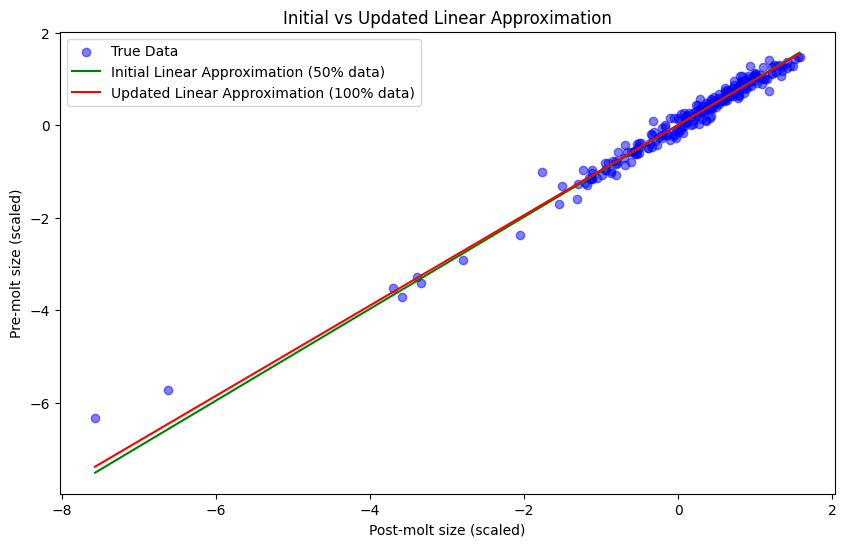

In [32]:
# Define linear approximation functions for plotting
def initial_linear_approximation(x, beta0, beta1):
    return beta0 + beta1 * x

def updated_linear_approximation(x, beta_means):
    return beta_means['beta0'] + beta_means['beta1'] * x

# Generate predictions for the full data range
X_full = np.linspace(X_test_scaled.min(), X_test_scaled.max(), 100)
y_initial = initial_linear_approximation(X_full, np.mean(initial_samples['beta0']), np.mean(initial_samples['beta1']))
y_updated = updated_linear_approximation(X_full, final_means)

# Plot original data and both approximations
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled, y_test_scaled, color='blue', alpha=0.5, label="True Data")
plt.plot(X_full, y_initial, color='green', label="Initial Linear Approximation (50% data)")
plt.plot(X_full, y_updated, color='red', label="Updated Linear Approximation (100% data)")
plt.xlabel("Post-molt size (scaled)")
plt.ylabel("Pre-molt size (scaled)")
plt.title("Initial vs Updated Linear Approximation")
plt.legend()
plt.show()

In [33]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Define a Taylor series model with weights for each term
with pm.Model() as weighted_taylor_model:
    # Priors for the Taylor series coefficients
    beta0 = pm.Normal('beta0', mu=0, sigma=1)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)
    
    # Priors for weights associated with each term
    # Assuming higher-order terms start with priors close to zero
    w0 = pm.Beta('w0', alpha=5, beta=1)  # Weight for intercept term, centered near 1
    w1 = pm.Beta('w1', alpha=5, beta=1)  # Weight for linear term, centered near 1
    w2 = pm.Beta('w2', alpha=1, beta=5)  # Weight for quadratic term, centered near 0
    w3 = pm.Beta('w3', alpha=1, beta=5)  # Weight for cubic term, centered near 0
    
    # Define the weighted Taylor series model for y given x
    y_hat = (
        w0 * beta0 +
        w1 * beta1 * X_train_scaled.flatten() +
        w2 * beta2 * (X_train_scaled.flatten() ** 2) / 2 +
        w3 * beta3 * (X_train_scaled.flatten() ** 3) / 6
    )
    
    # Likelihood of observed data given weighted model
    sigma = 0.1  # assumed known likelihood standard deviation
    y_obs = pm.Normal('y_obs', mu=y_hat, sigma=sigma, observed=y_train_scaled)
    
    # MCMC sampling for both coefficients and weights
    trace_weighted = pm.sample(3000, return_inferencedata=True)

# Extract initial samples
initial_samples_weighted = {
    'beta0': trace_weighted.posterior['beta0'].values.flatten(),
    'beta1': trace_weighted.posterior['beta1'].values.flatten(),
    'beta2': trace_weighted.posterior['beta2'].values.flatten(),
    'beta3': trace_weighted.posterior['beta3'].values.flatten(),
    'w0': trace_weighted.posterior['w0'].values.flatten(),
    'w1': trace_weighted.posterior['w1'].values.flatten(),
    'w2': trace_weighted.posterior['w2'].values.flatten(),
    'w3': trace_weighted.posterior['w3'].values.flatten()
}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, beta3, w0, w1, w2, w3]


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 50 seconds.
There were 1544 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [34]:
# Function to update posterior samples with new data, including weights
def update_posterior_with_weights(y_new, x_new, current_samples):
    # Calculate predictions with weights
    predictions = (
        current_samples['w0'] * current_samples['beta0'] +
        current_samples['w1'] * current_samples['beta1'] * x_new +
        current_samples['w2'] * current_samples['beta2'] * (x_new ** 2) / 2 +
        current_samples['w3'] * current_samples['beta3'] * (x_new ** 3) / 6
    )
    
    # Calculate likelihood weights
    likelihood_weights = np.exp(-0.5 * ((y_new - predictions) ** 2) / sigma**2) / (np.sqrt(2 * np.pi) * sigma)
    likelihood_weights /= np.sum(likelihood_weights)  # Normalize

    # Resample to form the updated posterior
    updated_samples = {
        key: np.random.choice(values, size=len(values), p=likelihood_weights)
        for key, values in current_samples.items()
    }
    
    return updated_samples

# Sequentially update posterior with new data
updated_samples_weighted = initial_samples_weighted
for new_x, new_y in zip(X_new_scaled, y_new_scaled):
    updated_samples_weighted = update_posterior_with_weights(new_y, new_x, updated_samples_weighted)

# Calculate final means for each parameter and weight after updates
final_means_weighted = {key: np.mean(values) for key, values in updated_samples_weighted.items()}


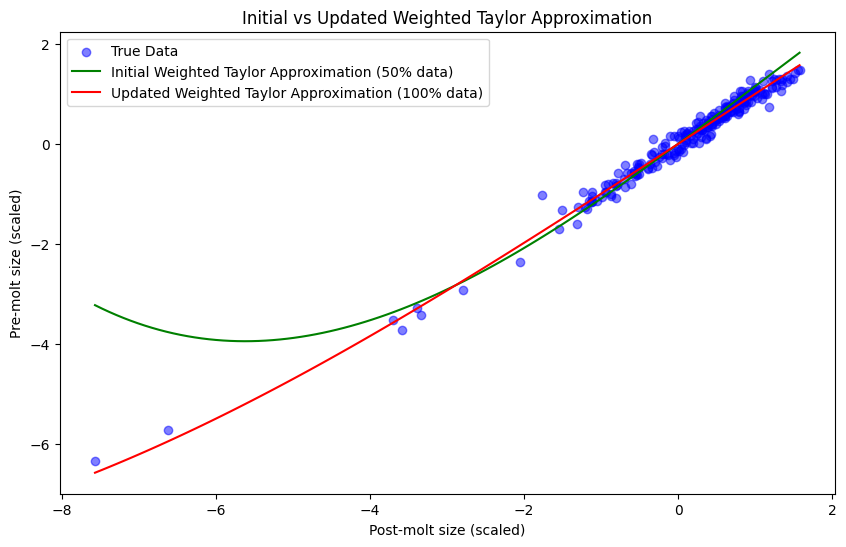

In [36]:
# Define functions for initial and updated weighted Taylor approximations
def initial_weighted_approximation(x, beta_means, weight_means):
    return (
        weight_means['w0'] * beta_means['beta0'] +
        weight_means['w1'] * beta_means['beta1'] * x +
        weight_means['w2'] * beta_means['beta2'] * (x ** 2) / 2 +
        weight_means['w3'] * beta_means['beta3'] * (x ** 3) / 6
    )

# Calculate the initial means for each parameter and weight from the initial samples
initial_means_weighted = {key: np.mean(values) for key, values in initial_samples_weighted.items()}

# Generate predictions using the initial and updated weighted approximations
X_full = np.linspace(X_test_scaled.min(), X_test_scaled.max(), 100)
y_initial_weighted = initial_weighted_approximation(X_full, initial_means_weighted, {'w0': 1, 'w1': 1, 'w2': 1, 'w3': 1})
y_updated_weighted = initial_weighted_approximation(X_full, final_means_weighted, final_means_weighted)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled, y_test_scaled, color='blue', alpha=0.5, label="True Data")
plt.plot(X_full, y_initial_weighted, color='green', label="Initial Weighted Taylor Approximation (50% data)")
plt.plot(X_full, y_updated_weighted, color='red', label="Updated Weighted Taylor Approximation (100% data)")
plt.xlabel("Post-molt size (scaled)")
plt.ylabel("Pre-molt size (scaled)")
plt.title("Initial vs Updated Weighted Taylor Approximation")
plt.legend()
plt.show()

